<a href="https://colab.research.google.com/github/yogeshprabhakar/cricket_data/blob/master/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os.path
import math
try:
    from urllib2 import urlopen
except ImportError:
    from urllib.request import urlopen
    
    
## This downloads your datafile, Do not change this function
def downloadFile(downloadUrl, dataSetId, instrumentId):
      fileName = '%s.csv' % (instrumentId)
      url = downloadUrl + dataSetId + '/' + fileName

      response = urlopen(url)
      status = response.getcode()
      if status == 200:
          print('Downloading the dataset %s' % (fileName))
          with open(fileName, 'w') as f:
              f.write(response.read().decode('utf8'))
          return True
      else:
          logError('File not found. Please ensure you are working with correct data set Id')
          return False

cachedFolderName='historicalData/'
dataSetId='p1'
instrumentIds=['trainingData']
downloadUrl = 'https://qq11-data.s3.amazonaws.com/'
targetVariable = 'Out'
timeKey = 'date'
startDateStr='2010/01/01'
endDateStr='2015/12/31'
if not os.path.isfile('%s.csv' % (instrumentIds[0])):
    downloadFile(downloadUrl, dataSetId, instrumentIds[0])
df = pd.read_csv('%s.csv' % (instrumentIds[0]), index_col=0, encoding='latin-1')

In [0]:
data50 = df.copy()
data50 = data50[data50.match_format == 50]
#Adding match_id
data50.reset_index(inplace=True)
data50['match_id'] = np.zeros(len(data50))
s1 = data50['innings_ball_number'] == 0
s1 *= 0.5
s1_cumsum = np.cumsum(s1)
s1_cumsum += 0.5
s1_cumsum = s1_cumsum.astype('int64')
data50['match_id'] = s1_cumsum

data50.set_index(keys = 'date', inplace = True)
data50_first = data50[data50["chasing"]==0]
data50_chase = data50[data50.chasing == 1]

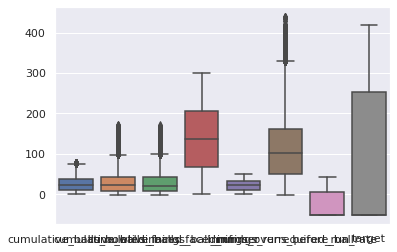

In [0]:
col = ['cumulative_balls_bowled', 'cumulative_balls_faced', 'cumulative_balls_faced_nf', 'innings_ball_number', 'innings_over', 'innings_runs_before_ball', 'required_run_rate', 'target', ]
#sns.boxplot( data = data50) 
sns.boxplot( data = data50[col])

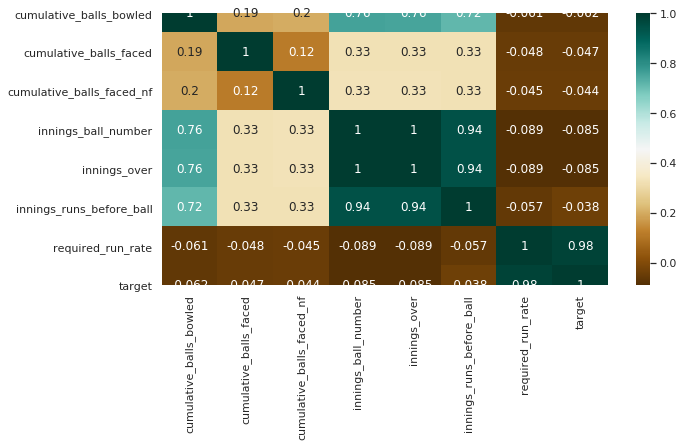

In [0]:
plt.figure(figsize=(10,5))
c= data50[col].corr()
g = sns.heatmap(c,cmap='BrBG',annot=True)
plt.show(g)

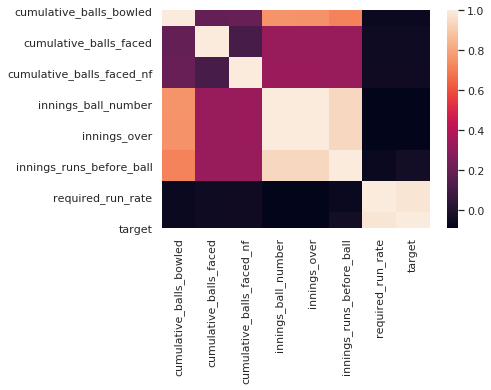

In [0]:
c= data50[col].corr()
sns.heatmap(c)

In [0]:
data50_chasing_train = data50_chase.copy()[:165444]
data50_chasing_test = data50_chase.copy()[165444:]

In [0]:
#data50_chasing_train.groupby()

In [0]:
#Bowler : Career figures like strike rate, average, last 5 match figures
#Batsman : runs in last 5 matches, career average, career strike rate, strike rate in last 5 matches

##Below function adds the following features:
## State of the game features:
##  tossWin: Did the batting team win the toss?
##  runRateLast5: runRate in last 5 overs
##  wicketsLast5: wickets in last 5 overs
##  runsLast6: runs in last 6 balls

## Bowler form features
##  bowlerRunsLast6 : runs given by bowler in last 6 balls
##  bowlerRunRateThisMatch: bowler economy in the game so far
##  bowlerWicketsThisMatch: wickets taken by the bowler in the game so far
##  bowlerRunsThisMatch: runs given by the bowler in the game so far

## we will try to predict these)
## wicketsNext6: wickets in last 6 balls

In [0]:

def NewFeatures(data):

    #state of the game features
    runsLast6=np.zeros(len(data))
    dotsLast6=np.zeros(len(data)) 
    tossWin = np.zeros(len(data))
    runRateLast5 = np.zeros(len(data))
    wicketsLast5 = np.zeros(len(data))
    runsNext6   = np.zeros(len(data))
    wicketsNext6 = np.zeros(len(data))
    runsNext = np.zeros(len(data))

    # bowler form features
    bowlerRunsLast6 = np.zeros(len(data))
    bowlerRunRateThisMatch = np.zeros(len(data))
    bowlerWicketsThisMatch = np.zeros(len(data))
    bowlerRunsThisMatch = np.zeros(len(data))

    ball_number_array= data['innings_ball_number']
    bowler_ball_number = data['cumulative_balls_bowled']
    bowler_name = data["bowler_name"]
    runs_array = data['innings_runs_before_ball']
    wickets = data['innings_wickets']
    toss_winner = data['toss_winner']
    batting_team_name = data['batting_team_name']
    for i in range(0,len(data)):
        if (i+1 < len(data)) and (ball_number_array[i+1]>0):
            runsNext[i] = runs_array[i+1] - runs_array[i]
        else:
            runsNext[i] = runsNext[i-1]

        if i+6 < len(data) and ball_number_array[i+6]>5:
            runsNext6[i] = runs_array[i+6] - runs_array[i]
        else:
            runsNext6[i] = runsNext6[i-1]

        if i+6 < len(data) and ball_number_array[i+6]>5:
            wicketsNext6[i] = int((wickets[i+6] - wickets[i])>0)
        else:
            wicketsNext6[i] = wicketsNext6[i-1]

        tossWin[i] = int(toss_winner[i]==batting_team_name[i])
        if ball_number_array[i]<30:
            runRateLast5[i] = (runs_array[i]/(ball_number_array[i]+1))*6
            wicketsLast5[i] = wickets[i]
        else:
            runRateLast5[i] = (runs_array[i] - runs_array[i-30])/5
            wicketsLast5[i] = wickets[i] - wickets[i-30]

        if ball_number_array[i]<6:
            runsLast6[i] = (runs_array[i]/(ball_number_array[i]+1))*6
        else:
            runsLast6[i] = runs_array[i] - runs_array[i-6]

        bowler = bowler_name[i]

        j = 1
        while True:
            if bowler_ball_number[i] == 0:
                bowlerRunsThisMatch[i] = 0
                bowlerWicketsThisMatch[i] = 0
                break
            if bowler_name[i - j] == bowler:
                bowlerRunsThisMatch[i] = bowlerRunsThisMatch[i - j] + (runs_array[i - j + 1] - runs_array[i - j])
                bowlerWicketsThisMatch[i] = bowlerWicketsThisMatch[i - j] + (wickets[i - j + 1] - wickets[i - j])
                break
            j += 1

        if bowler_ball_number[i] == 0:
            bowlerRunRateThisMatch[i] = 4
        else:
            bowlerRunRateThisMatch[i] = (bowlerRunsThisMatch[i] / bowler_ball_number[i]) * 6


    data['runsLast6'] = runsLast6
    data['tossWin'] = tossWin
    data['runRateLast5'] = runRateLast5
    data['wicketsLast5'] = wicketsLast5
    data['wicketsNext6'] = wicketsNext6
    data['runsNext6'] = runsNext6
    data['runsNext'] = runsNext

    data['bowlerRunsLast6'] = bowlerRunsLast6
    data['bowlerRunRateThisMatch'] = bowlerRunRateThisMatch
    data['bowlerWicketsThisMatch'] = bowlerWicketsThisMatch

    # data=data.drop(columns=["toss_winner", "batting_team_name"])
    return None

In [0]:
NewFeatures(data50_chasing_train)
NewFeatures(data50_chasing_test)

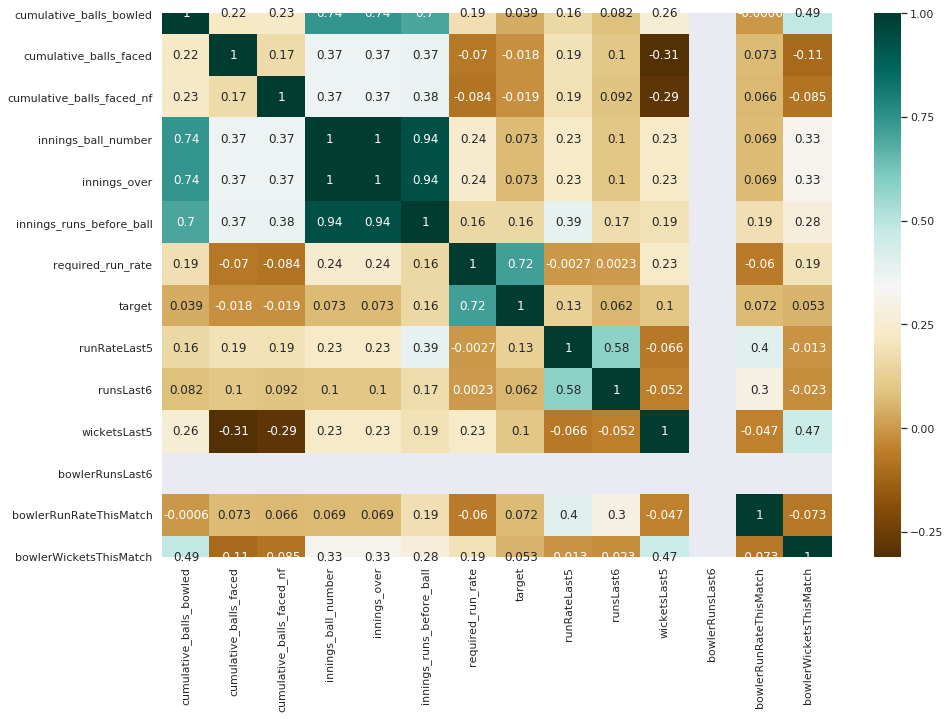

In [0]:
col = ['cumulative_balls_bowled', 'cumulative_balls_faced', 'cumulative_balls_faced_nf', 'innings_ball_number', 'innings_over', 'innings_runs_before_ball', 'required_run_rate', 'target','runRateLast5', 'runsLast6', 'wicketsLast5', 'bowlerRunsLast6','bowlerRunRateThisMatch', 'bowlerWicketsThisMatch']
plt.figure(figsize=(15,10))
c= data50_chasing_test[col].corr()
g = sns.heatmap(c,cmap='BrBG',annot=True)
plt.show(g)

In [0]:
drop_columns_3 = ['batsman_name','batsman_number', 'batting_team_name',"bowler_name","bowling_team_name", "country_group", "innings", "match_format", 'toss_choice',"toss_winner",'match_quality','venue_name']
drop_columns_4 = ['batsman_name','batting_team_name',"bowler_name","bowling_team_name", "country_group", "innings", "match_format", 'toss_choice',"toss_winner",'match_quality','venue_name','match_id']

data50_chasing_train = data50_chasing_train.drop(columns=drop_columns_4)
data50_chasing_test = data50_chasing_test.drop(columns=drop_columns_4)

In [0]:
from sklearn import preprocessing

feature_dict ={}
for feature in data50_chasing_train.columns:
    if data50_chasing_train[feature].dtype==object:
        le = preprocessing.LabelEncoder()
        fs = data50_chasing_train[feature].unique()
        f_dict = {}
        le.fit(fs)
        data50_chasing_train[feature] = le.transform(data50_chasing_train[feature])
        data50_chasing_test[feature] = le.transform(data50_chasing_test[feature])
        feature_dict[feature] = le

In [0]:
target_cols = data50_chasing_train[['runsNext6','runsNext','wicketsNext6']]
data50_chasing_train.drop(['runsNext6','runsNext','wicketsNext6'],axis=1,inplace=True)

In [0]:
target_cols_test = data50_chasing_test[['runsNext6','runsNext','wicketsNext6']]
data50_chasing_test.drop(['runsNext6','runsNext','wicketsNext6'],axis=1,inplace=True)

In [0]:
from sklearn.metrics import accuracy_score, r2_score, confusion_matrix, classification_report
from sklearn.metrics import classification_report

In [0]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

maxdepth_list = [ 6, 8]

for d in maxdepth_list:
  rforest_model_wickets_next6 = RandomForestClassifier(n_estimators=150, max_depth=d,random_state=0).fit(data50_chasing_train,target_cols['wicketsNext6'])
  wicketsNext6_tr = rforest_model_wickets_next6.predict(data50_chasing_train)
  wicketsNext6_ts = rforest_model_wickets_next6.predict(data50_chasing_test)
  print('accuracy of wicketsNext6 is :{}'.format(accuracy_score(target_cols_test['wicketsNext6'],wicketsNext6_ts)))
  print('accuracy of wicketsNext6_tr is :{}'.format(accuracy_score(target_cols['wicketsNext6'],wicketsNext6_tr)))
  #print('dummy model accuracy of wicketsNext6 is :{}'.format(accuracy_score(target_cols_test['wicketsNext6'],baseline)))
  print(confusion_matrix(target_cols_test['wicketsNext6'],wicketsNext6_ts))
  print(classification_report(target_cols_test['wicketsNext6'],wicketsNext6_ts) )
  importances = rforest_model_wickets_next6.feature_importances_
  print(importances)
  print('')

## creating feeder models 


accuracy of wicketsNext6 is :0.8826880651652161
accuracy of wicketsNext6_tr is :0.8794818790648196
[[35380     5]
 [ 4834  1030]]
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94     35385
         1.0       1.00      0.18      0.30      5864

    accuracy                           0.88     41249
   macro avg       0.94      0.59      0.62     41249
weighted avg       0.90      0.88      0.85     41249

[4.28643208e-04 1.18338464e-02 5.63157632e-04 7.92754020e-04
 9.00243159e-03 6.03730953e-03 5.23668240e-03 3.97602906e-02
 3.27967880e-02 1.73176660e-02 2.83983496e-02 1.79099287e-04
 1.22442476e-02 4.41890219e-02 9.04057091e-03 0.00000000e+00
 1.26627949e-03 7.61652927e-01 2.41206687e-03 5.64556234e-04
 6.59785117e-03 4.81407052e-03 0.00000000e+00 2.70751085e-03
 2.16387967e-03]

accuracy of wicketsNext6 is :0.882712308177168
accuracy of wicketsNext6_tr is :0.880745146393946
[[35368    17]
 [ 4821  1043]]
              precision    reca

In [0]:
baseline = np.zeros(41249)

print('dummy model accuracy of wicketsNext6 is :{}'.format(accuracy_score(target_cols_test['wicketsNext6'],baseline)))



dummy model accuracy of wicketsNext6 is :0.8578389779146162


In [0]:
colu = data50_chasing_train.columns
fe = [9.69657351e-04, 1.17705391e-02, 1.04322745e-03, 1.21964728e-03, 1.01966227e-02, 1.05328552e-02, 9.50070857e-03, 3.86772717e-02, 2.69818247e-02, 1.93564890e-02, 2.84997542e-02, 6.92784578e-04, 1.09941998e-02, 4.65207821e-02, 1.61935306e-02, 0.00000000e+00, 1.93063497e-03, 7.28469095e-01, 5.51054692e-03, 1.77191145e-03, 1.10844810e-02, 6.39833829e-03, 0.00000000e+00, 7.44822806e-03, 4.23687015e-03]
fea = pd.DataFrame(data = fe, index = colu)
#fea.reset_index()
fea.columns = ['importance']
fea

,importance
batsman_hand,0.000970
batsman_number,0.011771
bowler_hand,0.001043
bowler_style,0.001220
cumulative_balls_bowled,0.010197
cumulative_balls_faced,0.010533
cumulative_balls_faced_nf,0.009501
innings_ball_number,0.038677
innings_over,0.026982
innings_runs_before_ball,0.019356


In [0]:
from sklearn.preprocessing import Normalizer
scaler = Normalizer().fit(data50_chasing_train)
normalized_X_train = scaler.transform(data50_chasing_train)
normalized_X_test = scaler.transform(data50_chasing_test)

In [0]:
from sklearn import neighbors

k_list = [12, 15, 20]

for n in k_list:
  knn = neighbors.KNeighborsClassifier(n_neighbors = n)
  knn_model_wicket6 = knn.fit(normalized_X_train,target_cols['wicketsNext6'])
  knn_wicketsNext6_tr = knn_model_wicket6.predict(normalized_X_train)
  knn_wicketsNext6_ts = knn_model_wicket6.predict(normalized_X_test)
  print('accuracy of wicketsNext6 is :{}'.format(accuracy_score(target_cols_test['wicketsNext6'],knn_wicketsNext6_ts)))
  print('accuracy of wicketsNext6_tr is :{}'.format(accuracy_score(target_cols['wicketsNext6'],knn_wicketsNext6_tr)))
  print(confusion_matrix(target_cols_test['wicketsNext6'],knn_wicketsNext6_ts) )
  print(classification_report(target_cols_test['wicketsNext6'],knn_wicketsNext6_ts) )
  print('')


accuracy of wicketsNext6 is :0.8448447235084486
accuracy of wicketsNext6_tr is :0.8684267788496409
[[34616   769]
 [ 5631   233]]
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92     35385
         1.0       0.23      0.04      0.07      5864

    accuracy                           0.84     41249
   macro avg       0.55      0.51      0.49     41249
weighted avg       0.77      0.84      0.79     41249


accuracy of wicketsNext6 is :0.8440447041140391
accuracy of wicketsNext6_tr is :0.8663173037402384
[[34590   795]
 [ 5638   226]]
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.91     35385
         1.0       0.22      0.04      0.07      5864

    accuracy                           0.84     41249
   macro avg       0.54      0.51      0.49     41249
weighted avg       0.77      0.84      0.79     41249


accuracy of wicketsNext6 is :0.8515600378190986
accuracy of wicketsNext6_tr is :0.85

In [0]:
#from sklearn.svm import SVC
#svc = SVC(kernel='linear')
#svc = svc.fit(data50_chasing_train,target_cols['runsNext6'])
#svc_model_runs_next = svc.fit(data50_chasing_train,target_cols['runsNext'])
#svc_model_wicket6 = svc.fit(data50_chasing_train,target_cols['wicketsNext6'])

In [0]:
#svc_wicketsNext6_tr = knn_model_wicket6.predict(data50_chasing_train)
#svc_runsNext_tr = svc_model_runs_next.predict(data50_chasing_train)
#svc_runsNext6_tr = svc_model_runs_next6.predict(data50_chasing_train)
## adding predictions as features in the dataset
#data50_chasing_train['wicketsNext6'] = wicketsNext6
#data50_chasing_train['runsNext6'] = runsNext6
#data50_chasing_train['runsNext'] = runsNext

## predictions from these models 
#svc_wicketsNext6_ts = svc_model_wicket6.predict(data50_chasing_test)
#svc_runsNext_ts = svc_model_runs_next.predict(data50_chasing_test)
#svc_runsNext6_ts = svc_model_runs_next6.predict(data50_chasing_test)

In [0]:
#print('accuracy of wicketsNext6 is :{}'.format(accuracy_score(target_cols_test['wicketsNext6'],svc_wicketsNext6_ts)))
#print('accuracy of runsNext6 is :{}'.format(r2_score(target_cols_test['runsNext6'],svc_runsNext_ts )))
#print('accuracy of runsNextis :{}'.format(r2_score(target_cols_test['runsNext'],svc_runsNext6_ts )))

In [0]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb_model_wicket6 = gnb.fit(normalized_X_train,target_cols['wicketsNext6'])

In [0]:
gnb_wicketsNext6_tr = gnb_model_wicket6.predict(normalized_X_train)
gnb_wicketsNext6_ts = gnb_model_wicket6.predict(normalized_X_test)

In [0]:
print('accuracy of wicketsNext6 is :{}'.format(accuracy_score(target_cols_test['wicketsNext6'],gnb_wicketsNext6_ts)))
print('accuracy of wicketsNext6_tr is :{}'.format(accuracy_score(target_cols['wicketsNext6'],gnb_wicketsNext6_tr)))
print(confusion_matrix(target_cols_test['wicketsNext6'],gnb_wicketsNext6_ts) )
print(classification_report(target_cols_test['wicketsNext6'],gnb_wicketsNext6_ts) )


accuracy of wicketsNext6 is :0.8816213726393367
accuracy of wicketsNext6_tr is :0.8770580982084573
[[35319    66]
 [ 4817  1047]]
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94     35385
         1.0       0.94      0.18      0.30      5864

    accuracy                           0.88     41249
   macro avg       0.91      0.59      0.62     41249
weighted avg       0.89      0.88      0.85     41249



In [0]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
minmax_X_train = scaler.fit_transform(data50_chasing_train)
minmax_X_test = scaler.transform(data50_chasing_test)
maxdepth_list = [ 1, 2, 3, 4, 5, 6, 7, 8, 9]

for d in maxdepth_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=1, max_features=d, max_depth=6, random_state=0)
    gb_clf.fit(minmax_X_train, target_cols['wicketsNext6'])
    GradientBoostingClassifier_wicketsNext6_tr = gb_clf.predict(minmax_X_train)
    GradientBoostingClassifier_wicketsNext6_ts = gb_clf.predict(minmax_X_test)

    print("Learning rate: ", d)
    print("Accuracy score (training): {}".format(accuracy_score(target_cols['wicketsNext6'], GradientBoostingClassifier_wicketsNext6_tr)))
    print("Accuracy score (validation): {}".format(accuracy_score(target_cols_test['wicketsNext6'], GradientBoostingClassifier_wicketsNext6_ts)))
    print(confusion_matrix(target_cols_test['wicketsNext6'], GradientBoostingClassifier_wicketsNext6_ts) )
    print(classification_report(target_cols_test['wicketsNext6'], GradientBoostingClassifier_wicketsNext6_ts) )
    print('')


Learning rate:  1
Accuracy score (training): 0.8819781920166341
Accuracy score (validation): 0.8749303013406385
[[34940   445]
 [ 4714  1150]]
              precision    recall  f1-score   support

         0.0       0.88      0.99      0.93     35385
         1.0       0.72      0.20      0.31      5864

    accuracy                           0.87     41249
   macro avg       0.80      0.59      0.62     41249
weighted avg       0.86      0.87      0.84     41249


Learning rate:  2
Accuracy score (training): 0.883809627426803
Accuracy score (validation): 0.874639385197217
[[34876   509]
 [ 4662  1202]]
              precision    recall  f1-score   support

         0.0       0.88      0.99      0.93     35385
         1.0       0.70      0.20      0.32      5864

    accuracy                           0.87     41249
   macro avg       0.79      0.60      0.62     41249
weighted avg       0.86      0.87      0.84     41249


Learning rate:  3
Accuracy score (training): 0.8843475738014

In [0]:
#Decison tree, Gradient booster, Naive bayes, logistic regression, svm,  

In [0]:
from sklearn.linear_model import LogisticRegression

c_list = [50, 75, 100, 125, 150]
for c in c_list:
  elf = LogisticRegression(C = c).fit(minmax_X_train, target_cols['wicketsNext6'])
  elfClassifier_wicketsNext6_tr = elf.predict(minmax_X_train)
  elfClassifier_wicketsNext6_ts = elf.predict(minmax_X_test)

  print("C rate: ", c)
  print("Accuracy score (training): {}".format(accuracy_score(target_cols['wicketsNext6'], elfClassifier_wicketsNext6_tr)))
  print("Accuracy score (validation): {}".format(accuracy_score(target_cols_test['wicketsNext6'], elfClassifier_wicketsNext6_ts)))
  print(confusion_matrix(target_cols_test['wicketsNext6'], elfClassifier_wicketsNext6_ts) )
  print(classification_report(target_cols_test['wicketsNext6'], elfClassifier_wicketsNext6_ts) )
  print('')

  


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C rate:  50
Accuracy score (training): 0.8783818089504606
Accuracy score (validation): 0.8819365317947102
[[35349    36]
 [ 4834  1030]]
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94     35385
         1.0       0.97      0.18      0.30      5864

    accuracy                           0.88     41249
   macro avg       0.92      0.59      0.62     41249
weighted avg       0.89      0.88      0.84     41249




/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C rate:  75
Accuracy score (training): 0.8783818089504606
Accuracy score (validation): 0.8819365317947102
[[35349    36]
 [ 4834  1030]]
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94     35385
         1.0       0.97      0.18      0.30      5864

    accuracy                           0.88     41249
   macro avg       0.92      0.59      0.62     41249
weighted avg       0.89      0.88      0.84     41249




/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C rate:  100
Accuracy score (training): 0.8783818089504606
Accuracy score (validation): 0.8819365317947102
[[35349    36]
 [ 4834  1030]]
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94     35385
         1.0       0.97      0.18      0.30      5864

    accuracy                           0.88     41249
   macro avg       0.92      0.59      0.62     41249
weighted avg       0.89      0.88      0.84     41249




/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C rate:  125
Accuracy score (training): 0.8783818089504606
Accuracy score (validation): 0.8819365317947102
[[35349    36]
 [ 4834  1030]]
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94     35385
         1.0       0.97      0.18      0.30      5864

    accuracy                           0.88     41249
   macro avg       0.92      0.59      0.62     41249
weighted avg       0.89      0.88      0.84     41249




/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C rate:  150
Accuracy score (training): 0.8783818089504606
Accuracy score (validation): 0.8819365317947102
[[35349    36]
 [ 4834  1030]]
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94     35385
         1.0       0.97      0.18      0.30      5864

    accuracy                           0.88     41249
   macro avg       0.92      0.59      0.62     41249
weighted avg       0.89      0.88      0.84     41249




In [0]:
data50.match_id.max()
(len(data50) - 12*data50.match_id.max())/len(data50)

0.9777104752796153

In [0]:
df.country_group.unique()

array(['australia', 'bangladesh', 'sri lanka', 'new zealand',
       'south africa', 'middle east', 'india', 'west indies', 'pakistan',
       'north america', 'zimbabwe', 'uk', 'europe', 'east asia'],
      dtype=object)

In [0]:
(data50_chase.Out != 0).sum()

5460

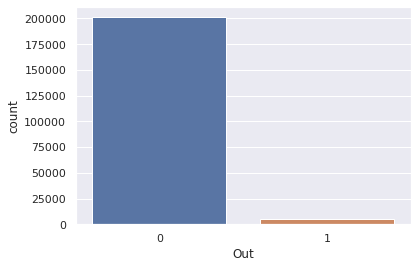

In [0]:
sns.set(style="darkgrid")
ax = sns.countplot(x = 'Out', data=data50_chase)